In [23]:
# importing required libraries


from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras

import pandas as pd
import cv2

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

from scipy.misc import imresize

In [24]:
from keras.datasets import fashion_mnist
from keras import backend as K
# load and pre-process data

if K.image_data_format() == 'channels_first':
    input_shape = (1, 28, 28)  # image shape
else:
    input_shape = (28, 28, 1)  # image shape
    
def preprocess_input(x):
    return x.astype('float32').reshape((-1,) + input_shape) / 255


def preprocess_output(y):
    return keras.utils.to_categorical(y)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = map(preprocess_input, [x_train, x_test])
y_train, y_test = map(preprocess_output, [y_train, y_test])
print('Loading MNIST data...')
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape, 'y_test shape', y_test.shape)

Loading MNIST data...
x_train shape: (60000, 28, 28, 1) y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1) y_test shape (10000, 10)


In [25]:
# read images

#from mnist import MNIST

#train_path="/home/lemos/Cursos/a-comprehensive-learning-path-for-deep-learning-in-2019/Identify the digits/Images/pretrained/uncompressed"
#test_path="/home/lemos/Cursos/a-comprehensive-learning-path-for-deep-learning-in-2019/Identify the digits/Images/pretrained/uncompressed"

#mndata = MNIST(train_path)

#train, train_labels = mndata.load_training()
#test, test_labels = mndata.load_testing()

In [26]:
from PIL import Image

# preparing the train dataset
train_img=[]
#for i in range(len(train)):
for i in range(3000):
    temp_img = Image.new("L", (28, 28))
    temp_img.putdata(x_train[i])
    temp_img = temp_img.resize((48,48)).convert('RGB')
    temp_img = image.img_to_array(temp_img)
    train_img.append(temp_img)
    


In [27]:

#converting train images to array and applying mean subtraction processing

train_img=np.array(train_img) 
#train_img=preprocess_input(train_img)


In [28]:
# preparing the test dataset
test_img=[]
#for i in range(len(test)):
for i in range(200):
    temp_img = Image.new("L", (28, 28))
    temp_img.putdata(x_test[i])
    temp_img = temp_img.resize((48,48)).convert('RGB')
    temp_img = image.img_to_array(temp_img)
    test_img.append(temp_img)

In [29]:
#converting test images to array and applying mean subtraction processing

test_img=np.array(test_img) 
#test_img=preprocess_input(test_img)

In [30]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

# loading VGG16 model weights
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
# Extracting features from the train dataset using the VGG16 pre-trained model
#features_train=model.predict(train_img)
# Extracting features from the test dataset using the VGG16 pre-trained model
#features_test=model.predict(test_img)
# flattening the layers to conform to MLP input
#train_x=features_train.reshape(3000,25088)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [31]:
train_y=np.array(y_train[0:3000])
test_Y = np.array(y_test[0:200]) 

# creating training and validation set
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label=train_test_split(train_img,train_y,test_size=0.2, random_state=13)

In [32]:


# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape



((2400, 48, 48, 3), (600, 48, 48, 3), (2400, 10), (600, 10))

In [33]:
num_classes = len(train_label[0])
num_classes


10

In [34]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_img), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)
#for layer in conv_base.layers:
#    layer.trainable = False

600/600 [==============================] - 3s 5ms/step


In [35]:
# 6.1 Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [36]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(2400, 1, 1, 512) 
 (200, 1, 1, 512) 
 (600, 1, 1, 512)


In [37]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (2400, 1*1*512))
test_features_flat = np.reshape(test_features, (200, 1*1*512))
val_features_flat = np.reshape(val_features, (600, 1*1*512))

In [38]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [39]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]


In [40]:
# creating a mlp model
#from keras.layers import Dense, Activation
#model=Sequential()


#model.add(Dense(1000, input_dim=(1*1*512), activation='relu',kernel_initializer='uniform'))
#keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)


#model.add(Dense(500,input_dim=1000,activation='sigmoid'))
#keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)


#model.add(Dense(150,input_dim=500,activation='sigmoid'))
#keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)


#model.add(Dense(units=10))
#model.add(Activation('softmax'))


#model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [41]:
# fitting the model 


#model.fit(X_train, Y_train, epochs=20, batch_size=128,validation_data=(X_valid,Y_valid))

In [42]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

W0831 19:50:19.032657 140041286600512 deprecation.py:323] From /home/lemos/miniconda3/envs/av/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 1s 349us/step - loss: 2.3408 - acc: 0.1163 - val_loss: 2.3510 - val_acc: 0.1350
Epoch 2/100
2400/2400 [==============================] - 0s 105us/step - loss: 2.3419 - acc: 0.1113 - val_loss: 2.3332 - val_acc: 0.0783
Epoch 3/100
2400/2400 [==============================] - 0s 100us/step - loss: 2.3361 - acc: 0.0983 - val_loss: 2.3260 - val_acc: 0.0817
Epoch 4/100
2400/2400 [==============================] - 0s 99us/step - loss: 2.3352 - acc: 0.0904 - val_loss: 2.3223 - val_acc: 0.0783
Epoch 5/100
2400/2400 [==============================] - 0s 118us/step - loss: 2.3203 - acc: 0.0946 - val_loss: 2.3154 - val_acc: 0.0817
Epoch 6/100
2400/2400 [==============================] - 0s 118us/step - loss: 2.3164 - acc: 0.1113 - val_loss: 2.3128 - val_acc: 0.1017
Epoch 7/100
2400/2400 [==============================] - 0s 107us/step - loss: 2.3260 - acc: 0.1029 - val_loss: 2.3128 - val_acc: 0.

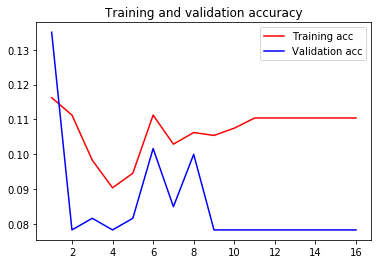

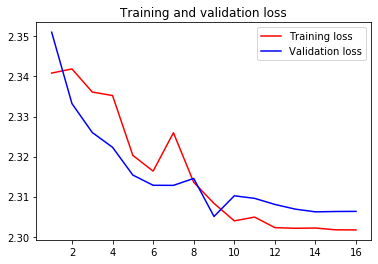

In [43]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()